Let us import the necessary libraries in python and load the data files


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Pandas is the library used to load the data.

In [2]:
data=pd.read_csv('./data/*.csv')
print(data.shape)
print(data.head())
print(data.describe())

(2000, 5)
          A         B         C         D  Class
0 -1.202659  0.324662  0.741053 -1.583113      1
1 -3.671058 -1.291171 -1.638048 -1.272242      0
2 -0.785138  4.033208  0.621245 -4.928067      1
3  1.196428  0.991209  0.633605 -0.075649      1
4  1.195653  3.383962 -1.419071 -2.386325      0
                 A            B            C            D        Class
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000
mean     -0.413139     1.543104     0.516940    -1.968688     0.500000
std       2.599385     2.034578     2.003351     1.559799     0.500125
min      -7.559413    -2.991272    -6.159370    -7.221440     0.000000
25%      -2.332368     0.044645    -0.839830    -3.118997     0.000000
50%      -0.406626     1.334586     0.704911    -1.986789     0.500000
75%       1.445181     2.902694     2.040135    -0.841876     1.000000
max       6.002363     8.282555     5.867292     2.675309     1.000000


The data is split into train, test and validation data. This is done using scikit learn library. The data frame is also converted into numpy array

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data.iloc[:,:4],data.iloc[:,-1] , test_size=200)

x_val,x_test, y_val, y_test = train_test_split(x_val,y_val , test_size=100)



x_train=np.array(x_train)
y_train=np.array(y_train)

x_val=np.array(x_val)
y_val=np.array(y_val)

x_test=np.array(x_test)
y_test=np.array(y_test)
print(x_train.shape,x_val.shape,x_test.shape,y_train.shape,y_val.shape,y_test.shape)


(1800, 4) (100, 4) (100, 4) (1800,) (100,) (100,)




Before going to the actual code let us consider some theoretical understanding of the Logistic regression model.


# Logistic Regression

Logistc regression is a classification algorithm. The probability P(Y|X) is the posterior probability which can be approximated using a sigmoid function on the linear combination of the input variables. For a single datapoint,

$$P(Y=y|X=x)= {\sigma(\theta^T x)}^y \cdot {[1-\sigma(\theta^T x)]}^{(1-y)}$$.

Assuming all data points are independent. We can write the likelihood as,

$$ {\cal{L}} (\theta) = \prod_{i}^{n} P(Y=y_i|X=x_i) $$
$$\hspace{3cm}  =  \prod_{i}^{n}  {\sigma(\theta^T x_i)}^{y_i} \cdot {[1-\sigma(\theta^T x_i)]}^{(1-y_i)}$$.


Taking the logarithm of the likelihood we obtain,
$${\cal{LL}} (\theta)=\sum_{i}^n y_i \log \sigma(\theta^Tx_i) + (1-y_i)\log (1-\sigma(\theta^T x_i))$$.


The cost function of the Logistic regression classifier is derived from the above formula,

$$J(\theta)= -\dfrac{1}{n}\big{[}\sum_{i}^n y_i \log \sigma(\theta^Tx_i) + (1-y_i)\log (1-\sigma(\theta^T x_i))\big{]}$$.

We want to minimize the cost function using the algorithm,

 Repeat until convergence,

$$ \theta_j := \theta_j - \alpha \dfrac{\partial J(\theta)}{\partial \theta_j}$$


This gradient descent algorithm is made more efficient by randomly choosing samples from the training dataset to optimize the cost function other than using the entire training dataset.


Inorder to avoid overfitting, we add regularization parameter to the cost function,

$$J(\theta)= -\dfrac{1}{n}\big{[}\sum_{i}^n y_i \log \sigma(\theta^Tx_i) + (1-y_i)\log (1-\sigma(\theta^T x_i))\big{]} + \dfrac{\lambda}{2n}\sum_{j=1}^m \theta_j^2$$.


The gradient descent then changes to,

Repeat until convergence,

$$ \theta_0 := \theta_0 - \alpha\dfrac{\partial J(\theta)}{\partial \theta_0} $$

$$ \theta_j := \theta_j - \alpha \big[\dfrac{\partial J(\theta)}{\partial \theta_j} + \dfrac{\lambda}{m} \theta_j\big]$$



In [4]:
import sys
from sklearn.metrics import accuracy_score,confusion_matrix
import re

class StochasticLogisticRegression(object):
    
       ##
    def __init__(self, dat_file):

        # check valid path to dat file supplied
        try:
            assert re.match(".*\.csv", dat_file)
        except AssertionError:
            print("Invalid (non .csv) file supplied")
            sys.exit(1)

        # get root of file name from path
        if re.match("\w+\.csv", dat_file):
            self.dat_file = "./" + dat_file

        # parse .dat into formatted array
        try:
            self.data = pd.read_csv(dat_file)
        except:
            print("failed to read .csv file {} : invalid formatting?".format(self.dat_file))
            sys.exit(1)
            
            
    def sigmoid(self,x):
        
        try :
            sigmoid_output=1/(1+np.exp(-x))
        except TypeError:
            print( "Invalid input type in sigmoid function. Please provide a numerical input")
            sys.exit(1)
            
        return sigmoid_output

    
    def cost(self,x,y,w,l):
        
        try:
            assert x.shape[1]+1==w.shape[0]
        except AssertionError:
            print("Invalid shape")
            sys.exit(1)
            
            
        z=np.dot(x,w[1:])+w[0] 
        
        p_1=y*np.log(self.sigmoid(z)) 
        p_2=(1-y)*np.log(1-self.sigmoid(z))
        rt=(l/(2*len(x))*sum((w[1:]**2)))
        s=-sum(p_1+p_2)/len(x)
        return (s)+rt         #The loss function -1/m[sum ylog(sigma(z))+(1-y)log(1-sigma(z))]+ lambda/2m sum theta^2
 
    def acc(self,y,y_pred):
        return(accuracy_score(y, np.around(y_pred)))

    def fit(self,x_train, y_train,x_val,y_val,l,batch_size=1, epochs=50, lr=0.05):        
        loss = []
        val_loss=[]
        accuracy=[]
        val_acc=[]

        # Random sample is drawn from a gaussian/normal distribution with mean 0 and 0.1 as standard deviation
        # Here the weight matrix contains bias term as well which is given by the first element of the weight matrix.
        
        weights = np.random.normal(0,0.1,x_train.shape[1]+1)  
        print(weights.shape)
        N = len(x_train)


        error=0
        for i in range(epochs):    
            
            """
            For stochastic gradient descent we choose random samples from the training data inorder to evaluate the cost function
            In standard stochastic gradient descent, the number of random sample is chosen as 1.
            In mini batch stochastic gradient descent a batch of small numbers is used to evaluate the cost.
                        
            """
            
            random_idx = np.random.choice(len(x_train), size=min(len(x_train), batch_size), replace = False)

            #validation_idx=np.random.choice(len(x_val), size=min(len(x_val), batch_size), replace = False)
           
            y_hat = self.sigmoid(np.dot(x_train[random_idx], weights[1:])+weights[0]) #The output is caclulated
            r=np.dot(l,weights[1:])#regularization
            r[0]=0  #The zeroth term corresponds to the bias term

            """The weights are updated here using the gradient formula given above."""
            
            
            weights[0]-=lr*(np.dot(1,y_hat - y_train[random_idx]))
            
            weights[1:] -= lr *(np.dot(x_train[random_idx].T,  y_hat - y_train[random_idx]) +r)/len(x_train[random_idx])            
            
            
            
            loss.append(self.cost(x_train, y_train, weights,l)) # We save the loss for the weights in every epoch
            val_loss.append(self.cost(x_val,y_val,weights,l))    
            accuracy.append(self.acc(y_train,self.sigmoid(np.dot(x_train,weights[1:]))+weights[0])) # Accuracy is also saved in every epoch
            val_acc.append(self.acc(y_val,self.sigmoid(np.dot(x_val,weights[1:]))+weights[0]))

            self.weights=weights
            self.loss=loss[i]
            self.val_loss=val_loss[i]
            self.accuracy=accuracy[i]
            self.val_acc=val_acc[i]
            
        return{'acc':accuracy,'val_acc':val_acc,'loss':loss, 'val_loss':val_loss, 'weights':weights}

    def predict(self,X):        
            # Predicting with sigmoid function
            z = np.dot(X, self.weights[1:])+self.weights[0]
            # Returning binary result
            return self.sigmoid(z)

In [5]:
# The model class is called here.
dat_file='./data/RDS-DL_take_home_task_data.csv'

model=StochasticLogisticRegression(dat_file)
model.data.describe()

,A,B,C,D,Class
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.413139,1.543104,0.516940,-1.968688,0.500000
std,2.599385,2.034578,2.003351,1.559799,0.500125
min,-7.559413,-2.991272,-6.159370,-7.221440,0.000000
25%,-2.332368,0.044645,-0.839830,-3.118997,0.000000
50%,-0.406626,1.334586,0.704911,-1.986789,0.500000
75%,1.445181,2.902694,2.040135,-0.841876,1.000000
max,6.002363,8.282555,5.867292,2.675309,1.000000


In [6]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data.iloc[:,:4],data.iloc[:,-1] , test_size=200)

x_val,x_test, y_val, y_test = train_test_split(x_val,y_val , test_size=100)

x_train=np.array(x_train)
y_train=np.array(y_train)

x_val=np.array(x_val)
y_val=np.array(y_val)

x_test=np.array(x_test)
y_test=np.array(y_test)
print(x_train.shape,x_val.shape,x_test.shape,y_train.shape,y_val.shape,y_test.shape)


(1800, 4) (100, 4) (100, 4) (1800,) (100,) (100,)


(5,)


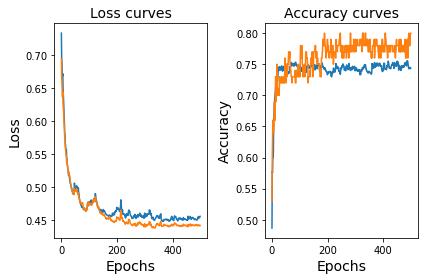

In [7]:
# We have given all the hyperparameters to the fit function.
history=model.fit(x_train,y_train,x_val,y_val,l=1,batch_size=1,epochs=500,lr=0.01)

# We can see how the performance of the model over the different iterations and 
# plot the loss and accuracy values at each epoch.

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(history['loss'])
ax[0].plot(history['val_loss'])
ax[0].set_ylabel('Loss',fontsize=14)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Loss curves',fontsize=14)


ax[1].plot(history['acc'])
ax[1].plot(history['val_acc'])
ax[1].set_ylabel('Accuracy',fontsize=14)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Accuracy curves',fontsize=14)

fig.tight_layout()

p=model.predict(x_test)


100


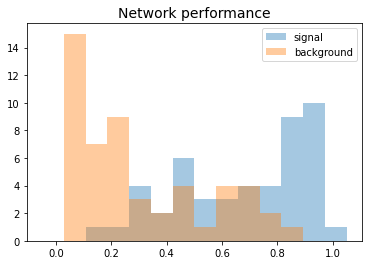

AUC:  0.8609775641025641


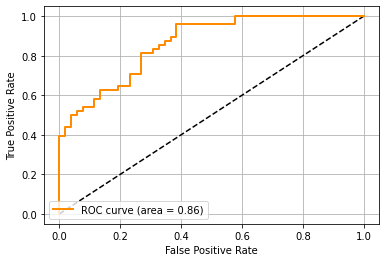

In [8]:
# Similarly, we can plot the overall performance of the network at a classification threshold of 0.5.
# In an ideal situation the histograms should be well separated creating a perfect classifier.


signals = []
backgrounds = []
truth=[]
print(len(y_test))
for i in range(len(y_test)):
    y = y_test[i]
    if y ==1:
        signals.append(p[i])
        truth.append(1)
    if y ==0:
        backgrounds.append(p[i])
        truth.append(0)
        
bins = np.linspace(-.05, 1.05, 15)


plt.hist(signals, bins, alpha=0.4, label='signal')
plt.hist(backgrounds,bins, alpha=0.4, label='background')
plt.title('Network performance',fontsize=14)
plt.legend(loc='upper right')
plt.show()


# Reciever-Operating-Characteristics can also be plotted from the classifier output.
# ROC curve gives the true positive rates and false positive rates for different classificaiton threshold.
# Area under the cure (AUC) is also a metric to calculate the performance.

from sklearn.metrics import roc_curve,auc



fprs, tprs, thresholds = roc_curve(y_test, p)

aucs = auc(fprs,tprs)
print ("AUC: ",aucs)


plt.plot([0, 1], [0, 1], '--', color='black')
plt.xlim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot(fprs,tprs, color='darkorange',lw=2, label='ROC curve (area = %0.2f)'  %aucs)
plt.grid(True)


plt.legend(fontsize=10,loc=3)



In [9]:
# We can save the model as a pickle file

import pickle as pkl
with open('./results/saved_model_notebook', 'wb') as file:  
    pkl.dump(model, file)


In [10]:
# The model is loaded and evaluated

with open('./results/saved_model_notebook', 'rb') as file:  
    saved_model = pkl.load(file)

p=saved_model.predict(x_test)

In [11]:
from sklearn.metrics import accuracy_score,confusion_matrix
print ("Accuracy: ",accuracy_score(y_test, np.around(p)))
print("Confusion Matrix: \n", confusion_matrix(y_test,np.around(p)))


Accuracy:  0.74
Confusion Matrix: 
 [[40 12]
 [14 34]]


In [12]:
test_model=StochasticLogisticRegression(dat_file)
def testSigmoid():
        assert model.sigmoid(0)==0.5
       # assert model.sigmoid(1)==0.73
def testCost():
        assert model.cost(x_train[:2,:],y_train[:2],np.array(np.zeros(5)),l=1)==0.693
        


# References


The code is built after going through multiple reference materials

1. https://www.ritchieng.com/logistic-regression/
2. https://www.robots.ox.ac.uk/~az/lectures/ml/2011/lect4.pdf
3. https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/pdfs/40%20LogisticRegression.pdf
4. https://towardsdatascience.com/logistic-regression-from-scratch-69db4f587e17
5. https://towardsdatascience.com/implementing-sgd-from-scratch-d425db18a72c